# Tower of Hanoi

In [3]:
from utils import *

## PROBLEM

Let's see how we define a Problem. Run the next cell to see how abstract class `Problem` is defined in the search module.

In [4]:
class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1
    

The `Problem` class has six methods.

* `__init__(self, initial, goal)` : This is what is called a `constructor`. It is the first method called when you create an instance of the class as `Problem(initial, goal)`. The variable `initial` specifies the initial state $s_0$ of the search problem. It represents the beginning state. From here, our agent begins its task of exploration to find the goal state(s) which is given in the `goal` parameter.


* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.


* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.


* `goal_test(self, state)` : Return a boolean for a given state - `True` if it is a goal state, else `False`.


* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.

## NODE

Let's see how we define a Node. Run the next cell to see how abstract class `Node` is defined in the search module.

In [5]:
class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state. Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node. Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """Build the child node"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of states to go from the root to this node."""
        return [node.state for node in self.path()]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state


The `Node` class has nine methods. The first is the `__init__` method.

* `__init__(self, state, parent, action, path_cost)` : This method creates a node. `parent` represents the node that this is a successor of and `action` is the action required to get from the parent node to this node. `path_cost` is the cost to reach current node from parent node.

The next 4 methods are specific `Node`-related functions.

* `expand(self, problem)` : This method lists all the neighbouring(reachable in one step) nodes of current node. 

* `child_node(self, problem, action)` : Given an `action`, this method returns the immediate neighbour that can be reached with that `action`.

* `solution(self)` : This returns the sequence of actions required to reach this node from the root node. 

* `path(self)` : This returns a list of all the nodes that lies in the path from the root to this node.

The remaining 3 methods override standards Python functionality for representing an object as a string, the less-than ($<$) operator, and the equal-to ($=$) operator.

* `__repr__(self)` : This returns the state of this node.

* `__lt__(self, node)` : Given a `node`, this method returns `True` if the state of current node is less than the state of the `node`. Otherwise it returns `False`.

* `__eq__(self, other)` : This method returns `True` if the state of current node is equal to the other node. Else it returns `False`.

## Hanoi

In [ ]:
class Hanoi(Problem):
    """ The problem of tower of hanoi """

    def __init__(self, n):
        """ Define goal state and initialize a problem """
        initial = 'A'*n
        goal = 'C'*n
        self.n = n
        super().__init__(initial, goal)

    def actions(self, state):
        """ Return the actions that can be executed in the given state.
        The result would be a list of tuples. For example, there are two actions
        in [(0,'B'), (0, 'C'), (3, 'C')] and the first action is (0,'B'), which
        means moving the 0th disk to peg B."""
        actions = []
        all_letters = ['A','B','C']
        changed_letters = set()
        
        current_letter = ""
        for disk_index, letter in enumerate(state):

            if letter in changed_letters:
                continue

            if letter != current_letter and current_letter == "":
                for next_letter in all_letters:
                    if next_letter != letter:
                        actions.append((disk_index,next_letter))
                        changed_letters.add(letter)
            elif letter != current_letter:
                for next_letter in all_letters:
                    if next_letter != letter and next_letter not in changed_letters:
                        actions.append((disk_index,next_letter))
                        changed_letters.add(letter)
            


            current_letter = letter
        
        
                
        return actions

    def result(self, state, action):
        """ Given state and action, return a new state that is the result of the action.
        Action is assumed to be a valid action in the state """

        new_state = state[:action[0]] + action[1] + state[action[0]+1:]
        return new_state

    def goal_test(self, state):
        """ Given a state, return True if state is a goal state or False, otherwise """

        return True if state == self.goal else False
    

    def h(self, node):
        """ Return the heuristic value for a given state."""

        # i mixed two methods here, one is counting not C
        # the other one is assigning weight to A and B
        # A is 2 because it is 2 places away from C and B is 1
        # if this heuristic is not admissible then i have another one like we discussed in class

        # this expands 14019 nodes - ADMISSIBLE BUT BASIC

        # n = 0
        # rev_node = "".join(reversed(node))
        # for index, char in enumerate(rev_node):
        #     if char != 'C':
        #         n += 1

        # return ((2**n)-1)

        if not 'C' in node:
            return len(node)
        
        n = 0
        min_c = float('inf')
        max_c = 0
        num_c = 0
        c_disks = []
        for index, char in enumerate(node):
            if char == 'C':
                min_c = min(min_c, index)
                max_c = max(max_c, index)
                c_disks.append(index)
                num_c += 1

        for index, char in enumerate(node):
            if char != 'C':
                if index < min_c:
                    n += 1
                elif index > max_c:
                    n += (num_c)+1
                else:
                    for j, disk in enumerate(c_disks):
                        if index > disk:
                            n += j-1
                            break
        
        return n
        



        # this expands 7262 nodes - NOT ADMISSIBLE

        # n = 0
        # for char in node:
        #     if char != 'C':
        #         n += 2 if char == 'A' else 1

        # return ((2**n)-1)

        # this expands 14277 nodes - NOT OPTIMAL

        # n = 0
        # disks_in_a = []
        # disks_in_b = []
        # disks_in_c = []
        # min_c = float('inf')
        # max_c = 0

        # for index, disk in enumerate(node):
        #     if disk == 'A':
        #         disks_in_a.append(index)
        #     elif disk == 'B':
        #         disks_in_b.append(index)
        #     else:
        #         disks_in_c.append(index)
        #         min_c = min(min_c, index)
        #         max_c = max(max_c, index)
        
        # for disk in disks_in_a:
        #     if disk > max_c:
        #         n += len(disks_in_c)*2
        #     else:
        #         n += 1
        
        # for disk in disks_in_b:
        #     if disk > max_c:
        #         n += len(disks_in_c)*2
        #     else:
        #         n += 1
        
        # return ((2**n)-1)
    
    def draw(self, solution = None):
        """ Draw Hanoi 
        solutin is a list of states from start to goal:
        - if solution is not provided, draw the graphical representation of the whole state space.
        - if solution is provided, draw it as a red path. 
        """
        Draw_Hanoi(self.n, solution).draw()

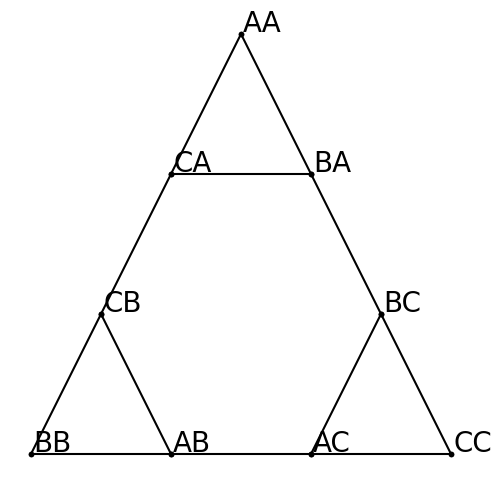

In [26]:
# Draw with 2 disks. 
puzzle = Hanoi(2)
puzzle.draw()

# for action in puzzle.actions('CBACBBCCBBA'):
#     print(puzzle.result('CBACBBCCBBA',action))


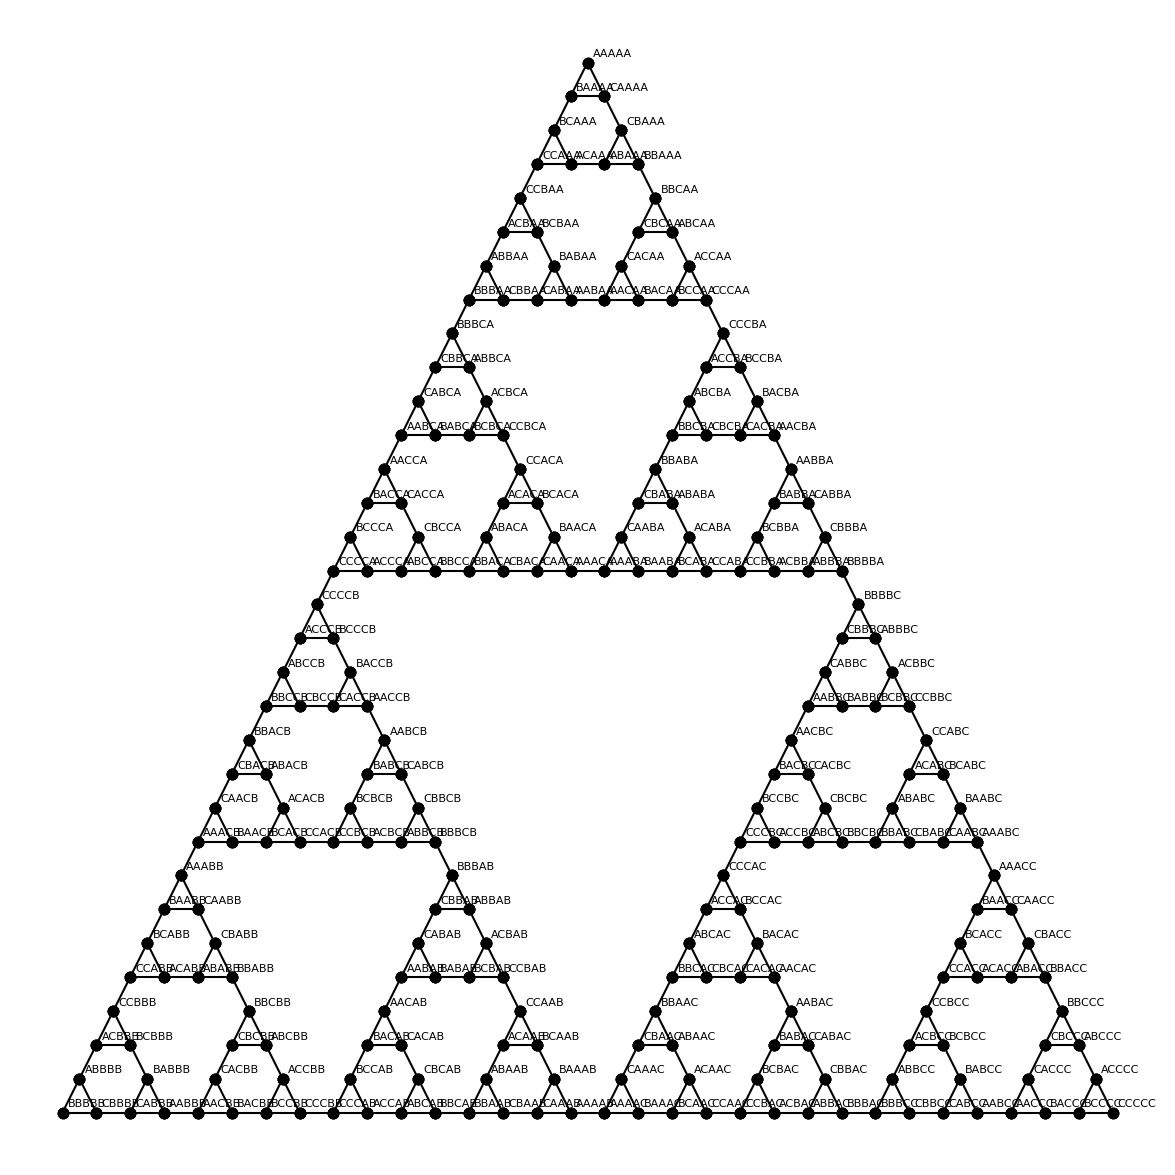

In [8]:
# Draw with 5 disks. 
puzzle = Hanoi(5)
puzzle.draw()

## BFS (25/100 points)

Write your code below to implement BFS.

In [18]:
def BFS(problem):
    """
    You need to use functions defined in Node and Problem classes such as:
        node.expand(problem)
        problem.goal_test()
        
    Your code returns the last node when the node reaches the goal. 
    """
    node = Node(problem.initial)

    container = Queue()
    container.push(node)
    visited_nodes = set()

    while not container.isEmpty():
        current_node = container.pop()

        if current_node.state in visited_nodes:
            continue
        else:
            visited_nodes.add(current_node.state)

        if problem.goal_test(current_node.state):
            return current_node
        
        for child_node in current_node.expand(problem):
            container.push(child_node)

    
    return node

['AA', 'BA', 'BC', 'CC']


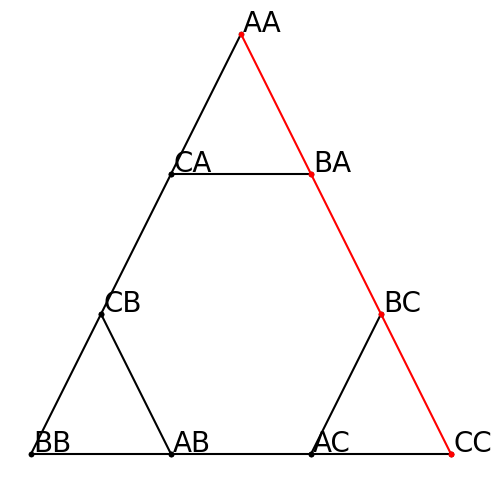

In [19]:
puzzle = Hanoi(2)

solution = ['AA', 'BA', 'BC', 'CC'] # expected solution
# uncomment this line to find the solution using your code. 
solution = BFS(puzzle).solution()

print(solution)
puzzle.draw(solution)

['AAAAA', 'CAAAA', 'CBAAA', 'BBAAA', 'BBCAA', 'ABCAA', 'ACCAA', 'CCCAA', 'CCCBA', 'BCCBA', 'BACBA', 'AACBA', 'AABBA', 'CABBA', 'CBBBA', 'BBBBA', 'BBBBC', 'ABBBC', 'ACBBC', 'CCBBC', 'CCABC', 'BCABC', 'BAABC', 'AAABC', 'AAACC', 'CAACC', 'CBACC', 'BBACC', 'BBCCC', 'ABCCC', 'ACCCC', 'CCCCC']


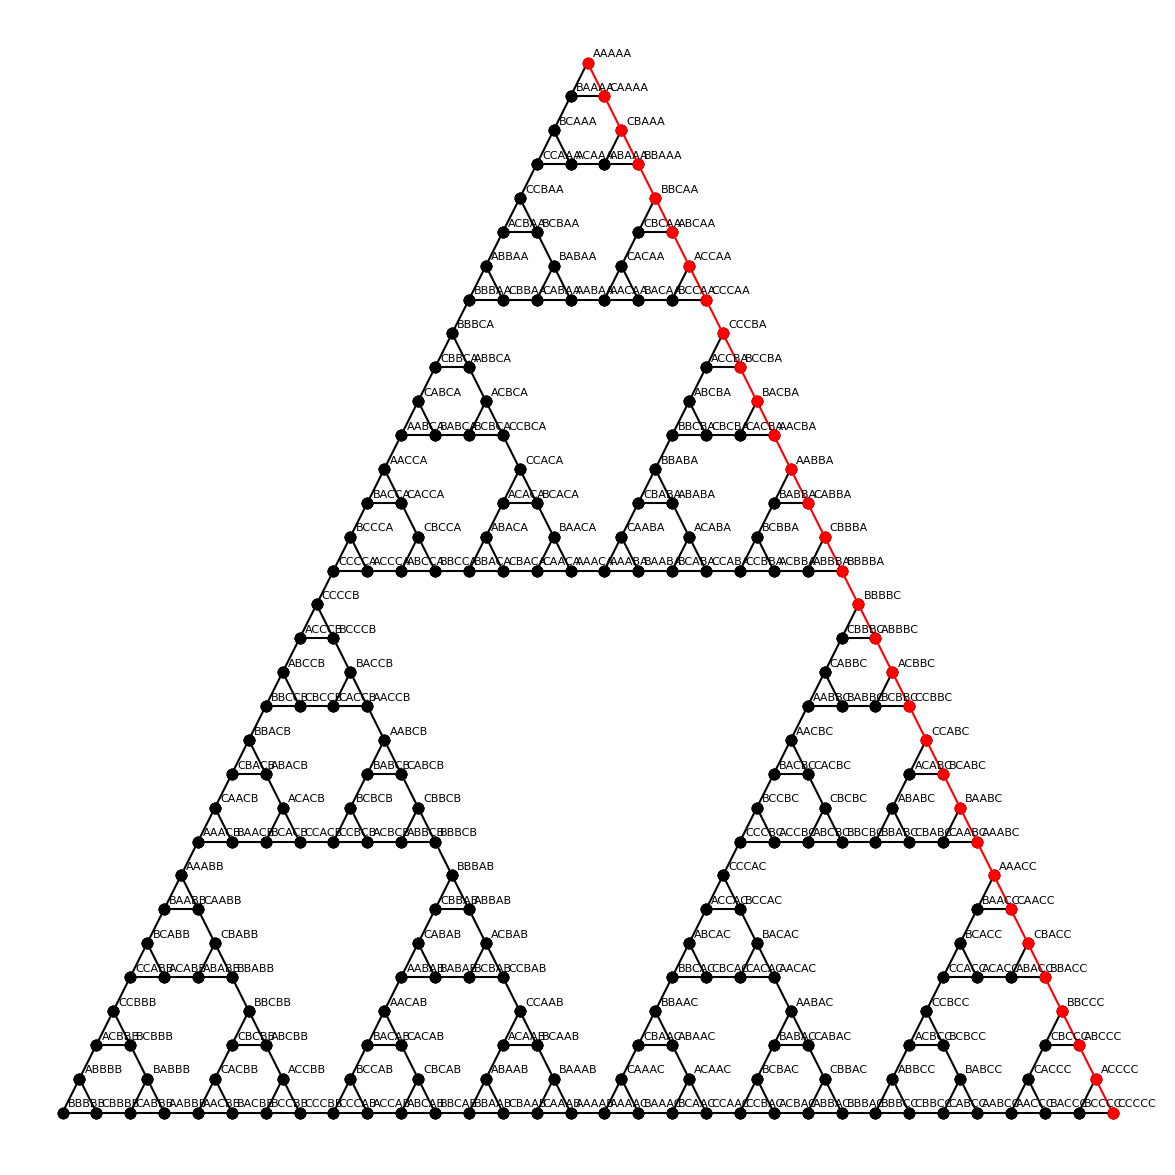

In [20]:
# test your code using 5 disks 
puzzle = Hanoi(5)
solution = BFS(puzzle).solution()
print(solution)
puzzle.draw(solution)

## DFS (25/100 points)

Write your code below to implement DFS.

In [12]:
def DFS(problem):
    """
    You need to use functions defined in Node and Problem classes such as:
        node.expand(problem)
        problem.goal_test()
        
    Your code returns the last node when the node reaches the goal. 
    """
    node = Node(problem.initial)
    # your code goes here:
    container = Stack()
    container.push(node)
    visited_nodes = set()

    while not container.isEmpty():
        current_node = container.pop()

        if current_node.state in visited_nodes:
            continue
        else:
            visited_nodes.add(current_node.state)

        if problem.goal_test(current_node.state):
            return current_node
        
        for child_node in current_node.expand(problem):
            container.push(child_node)
    
    
    return node

['AAAA', 'CAAA', 'CBAA', 'BBAA', 'BBCA', 'CBCA', 'CACA', 'BACA', 'BCCA', 'CCCA', 'CCCB', 'BCCB', 'BACB', 'CACB', 'CBCB', 'BBCB', 'BBAB', 'CBAB', 'CAAB', 'BAAB', 'AAAB', 'AAAC', 'CAAC', 'CBAC', 'BBAC', 'BBCC', 'CBCC', 'CACC', 'BACC', 'BCCC', 'CCCC']


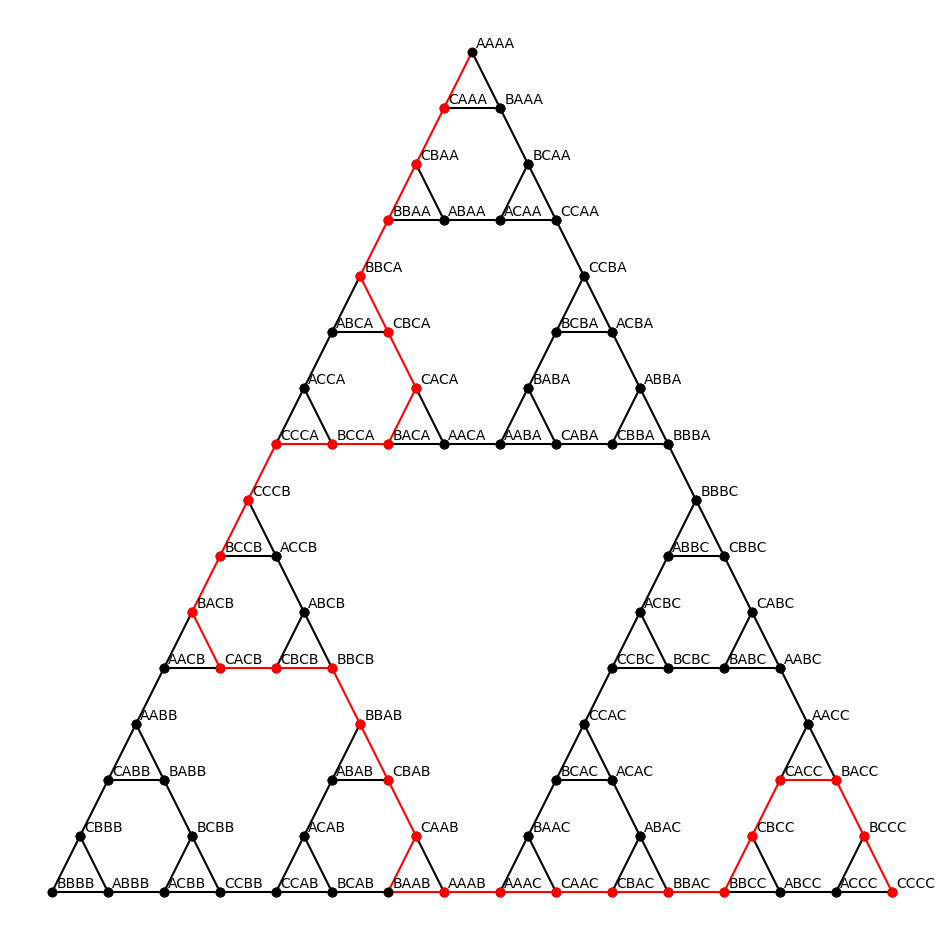

In [13]:
puzzle = Hanoi(4)

# expected solution
solution = ['AAAA', 'CAAA', 'CBAA', 'BBAA', 'BBCA', 'CBCA', 'CACA', 'BACA', 'BCCA', 'CCCA', 'CCCB', 'BCCB', 'BACB', 'CACB', 'CBCB', 'BBCB', 'BBAB', 'CBAB', 'CAAB', 'BAAB', 'AAAB', 'AAAC', 'CAAC', 'CBAC', 'BBAC', 'BBCC', 'CBCC', 'CACC', 'BACC', 'BCCC', 'CCCC']
 
# uncomment this line to find the solution using your code. 
solution = DFS(puzzle).solution()

print(solution)
puzzle.draw(solution)

['AAA', 'CAA', 'CBA', 'BBA', 'BBC', 'CBC', 'CAC', 'BAC', 'BCC', 'CCC']


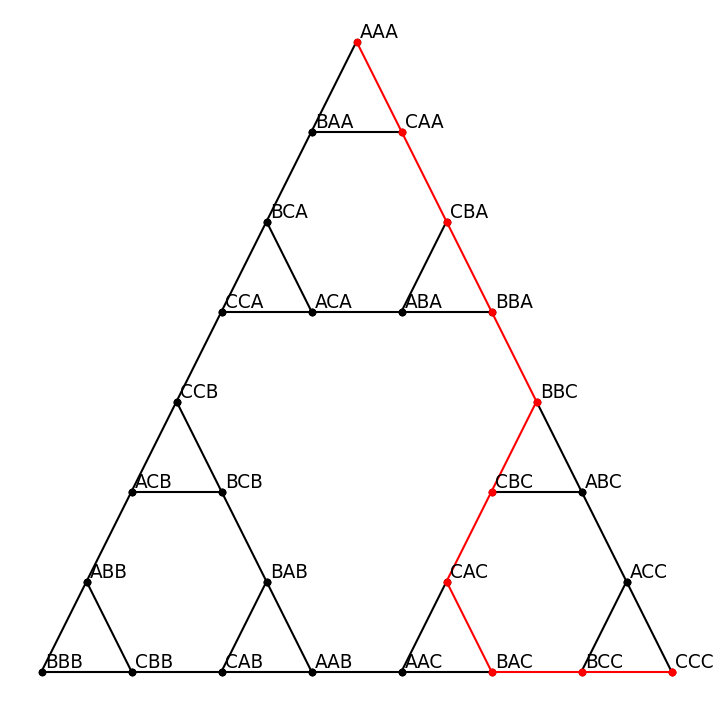

In [14]:
# test your code using 1-5 disks 
puzzle = Hanoi(3)
solution = DFS(puzzle).solution()
print(solution)
puzzle.draw(solution)

## A* (40/100 points)

Write your code below to implement A*.

In [15]:
def astar_search(problem, h=None):
    """
    You need to use functions defined in Node and Problem classes such as:
        node.expand(problem)
        problem.goal_test()
        
    A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass.
        
    Your code returns the last node when the node reaches the goal. 
    """
    
    if not h:
        h = problem.h
        
    node = Node(problem.initial)
    # your code goes here:
    container = PriorityQueue()
    container.push(node, problem.h(node.state))
    visited_nodes = set()

    expanded_node = 0

    while not container.isEmpty():
        current_node = container.pop()

        if current_node.state in visited_nodes:
            continue
        else:
            visited_nodes.add(current_node.state)

        if problem.goal_test(current_node.state):
            print(f"EXPANDED NODE: {expanded_node}")
            return current_node
        
        expanded_node += 1
        
        for child_node in current_node.expand(problem):
            container.push(child_node, problem.h(child_node.state))
    
    
    return node

EXPANDED NODE: 13
['AAA', 'BAA', 'BCA', 'ACA', 'ABA', 'BBA', 'BBC', 'ABC', 'ACC', 'CCC']


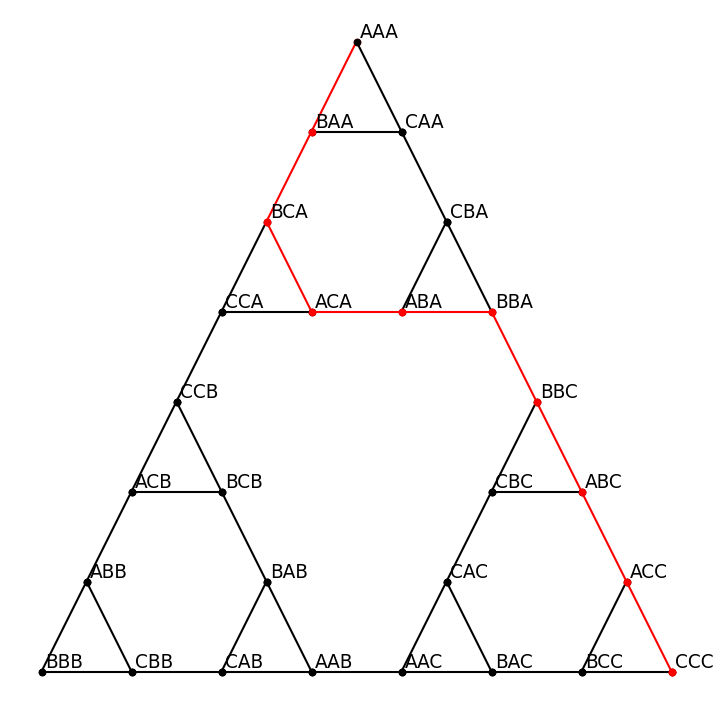

In [71]:
# test your code using 1-5 disks 
puzzle = Hanoi(3)
solution = astar_search(puzzle).solution()
print(solution)
puzzle.draw(solution)

## Count of expanded nodes in A* (10/100 points)


Please add a few lines of code to your A* implementation to count the number of expanded nodes. Typically, it looks like this:

```
expanded_node = 0
while frontier:
    ...
    if passing goal test:
        print("Explanded nodes is ", expanded_node)
    expanded_node += 1
    A for loop of children on current node
    ...
```

Then, run the code in the cell below to print out the number of expanded nodes using A* for a problem of size 9. The goal is to design an admissible heuristic function that is as efficient as possible.

Here is the grading table:

|    Number of Expanded Nodes | Points Adjusted from 10/100 |
|-------|-------|
| < 13000 |   + 15    | 
| < 13600 |   + 10    | 
| < 18000 |   0    | 
| < 19000 |   - 10    | 
| > 20000 |   - 15    | 

My current record is 13586. See if you can beat my record. 

In [70]:
puzzle = Hanoi(9)
astar_search(puzzle).solution()

EXPANDED NODE: 16232


['AAAAAAAAA',
 'BAAAAAAAA',
 'BCAAAAAAA',
 'ACAAAAAAA',
 'ABAAAAAAA',
 'BBAAAAAAA',
 'BBCAAAAAA',
 'CBCAAAAAA',
 'CACAAAAAA',
 'AACAAAAAA',
 'AABAAAAAA',
 'BABAAAAAA',
 'BCBAAAAAA',
 'ACBAAAAAA',
 'ABBAAAAAA',
 'BBBAAAAAA',
 'BBBCAAAAA',
 'ABBCAAAAA',
 'ACBCAAAAA',
 'CCBCAAAAA',
 'CCACAAAAA',
 'BCACAAAAA',
 'BAACAAAAA',
 'AAACAAAAA',
 'AAABAAAAA',
 'BAABAAAAA',
 'BCABAAAAA',
 'ACABAAAAA',
 'ABABAAAAA',
 'BBABAAAAA',
 'BBCBAAAAA',
 'CBCBAAAAA',
 'CACBAAAAA',
 'AACBAAAAA',
 'AABBAAAAA',
 'BABBAAAAA',
 'BCBBAAAAA',
 'ACBBAAAAA',
 'ABBBAAAAA',
 'BBBBAAAAA',
 'BBBBCAAAA',
 'CBBBCAAAA',
 'CABBCAAAA',
 'AABBCAAAA',
 'AACBCAAAA',
 'BACBCAAAA',
 'BCCBCAAAA',
 'CCCBCAAAA',
 'CCCACAAAA',
 'ACCACAAAA',
 'ABCACAAAA',
 'BBCACAAAA',
 'BBAACAAAA',
 'CBAACAAAA',
 'CAAACAAAA',
 'AAAACAAAA',
 'AAAABAAAA',
 'BAAABAAAA',
 'BCAABAAAA',
 'ACAABAAAA',
 'ABAABAAAA',
 'BBAABAAAA',
 'BBCABAAAA',
 'CBCABAAAA',
 'CACABAAAA',
 'AACABAAAA',
 'AABABAAAA',
 'BABABAAAA',
 'BCBABAAAA',
 'ACBABAAAA',
 'ABBABAAAA',
 'BBBA